In [ ]:
! pip install -U scikit-learn

In [ ]:
import numpy as np
import pandas as pd
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
from sklearn.model_selection import train_test_split
from fbprophet.plot import add_changepoints_to_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

import matplotlib.pyplot as plt
from google.colab import files
import io

In [ ]:
# This two lines read the train csv file and hen store it in the pandas dataframe format. Note that the file name must be train_a3.csv to work
uploaded = files.upload()
df_train_xy = pd.read_csv(io.BytesIO(uploaded['sales_data.csv']))

# Dropping the first column, since it does not contain relevant information and then inserting a column named 'cap'.
df_train_xy.drop(df_train_xy.columns[[0]], axis = 1, inplace = True)
df_train_xy.insert(1, 'cap', df_train_xy['y'] + 10000)

Saving train_a3.csv to train_a3.csv


In [ ]:
# This is a test cell used to tune the model for the training and validation set

# For logistic growth modelling, I also add the cap feature for the training set. While y column is the target of the model, where the two features can be used to
# for supervised learning against the target data.
date = df_train_xy[['ds', 'cap']]
target = df_train_xy.y

# I split the data for the validation test, where I test against the remaining 10 percent of the data. I do not shuffle
# the test set due to it being time series data.
X_train, X_test, y_train, y_test = train_test_split(date, target, test_size=0.10, random_state = 42,shuffle=False)

# merging the features with the target data to be fed into the prophet model
xy_train = pd.DataFrame({'ds': X_train['ds'].values, 'cap': X_train['cap'].values, 'y': y_train.values})

shopping_holidays = pd.DataFrame({
  'holiday': 'Shopping Holidays',
  'ds': pd.to_datetime(['2013-01-1', '2014-01-1', 
                        '2015-01-1', '2016-01-1',
                        '2017-01-1', '2013-12-25',
                        '2014-12-25', '2015-12-25',
                       '2016-12-25', '2017-12-25',
                        '2013-12-26', '2014-12-26',
                        '2015-12-26', '2016-12-26',
                        '2017-12-26']),
                        'lower_window': -2,
                        'upper_window': 2,
  })


# Here I have the two same prophet models, one linear and the other logistic
prophet_model = Prophet(n_changepoints=15, yearly_seasonality=True, weekly_seasonality=True, seasonality_prior_scale=0.3,
                        holidays= shopping_holidays, changepoint_prior_scale = 0.2)
# prophet_model = Prophet(n_changepoints=15, yearly_seasonality=True, weekly_seasonality=True, seasonality_prior_scale=0.3,
#                         holidays= shopping_holidays, growth='logistic')


prophet_model.fit(xy_train)

# create future set based on the trained model. I create the future set based on the length of the test set
prophet_future = prophet_model.make_future_dataframe(periods=len(y_test))

# Here, I create use the cap feature and then for the predicted values, I keep the capacity at a static 80,000. Meaning,
# the data before the predictions are the capacity values generated earlier, while the predicted values have the capacity set at 80,000
cap = pd.DataFrame(columns=['cap'])
for i in range(len(prophet_future)):
  if i < len(xy_train['cap']):
    cap.loc[i] = xy_train['cap'].loc[i]
  else:
    cap.loc[i] = 80000

# insert the capacity feature into the predicted future set and then make predictions based on it
prophet_future.insert(1, 'cap', cap['cap'].values)
prophet_forecast = prophet_model.predict(prophet_future)

# I take the prediction results from, which are in column 'yhat' and take the tail end of it. The tail end
# contains only the prediction results, which will then be used to test against the actual values to determine
# the accuracy of the prediction
predictions = prophet_forecast['yhat'].tail(len(y_test))

# Using the error calculator provided within the assignment to evaluate my results
def rmsle(y_hat, y):
    """Compute Root Mean Squared Logarithmic Error"""
    metric = np.sqrt(sum((np.array(list(map(lambda x : np.log(x + 1), y_hat)))
                         - np.array(list(map(lambda x : np.log(x + 1), y))))**2)/len(y))
    return round(metric, 4)

print('Test score: ' + str(rmsle(y_test, predictions)))



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Test score: 0.1245


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[[<matplotlib.lines.Line2D at 0x7f470924e610>],

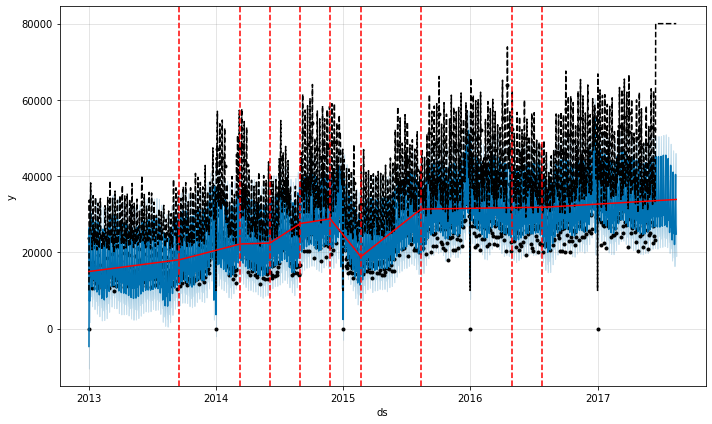

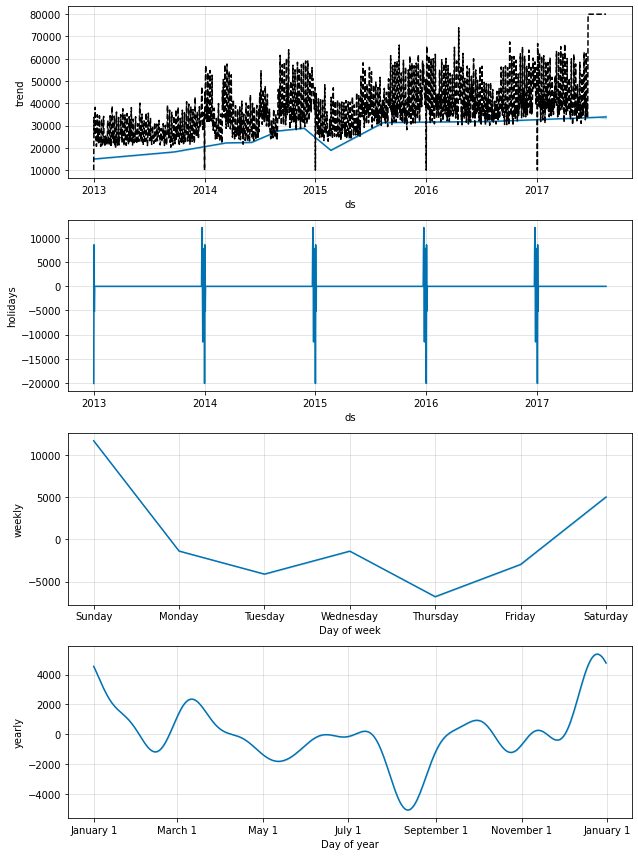

In [ ]:
shopping_holidays = pd.DataFrame({
  'holiday': 'Shopping Holidays',
  'ds': pd.to_datetime(['2013-01-1', '2014-01-1', 
                        '2015-01-1', '2016-01-1',
                        '2017-01-1', '2013-12-25',
                        '2014-12-25', '2015-12-25',
                       '2016-12-25', '2017-12-25',
                        '2013-12-26', '2014-12-26',
                        '2015-12-26', '2016-12-26',
                        '2017-12-26']),
                        'lower_window': -2,
                        'upper_window': 2,
  })

prophet_model = Prophet(n_changepoints=15, yearly_seasonality=True, weekly_seasonality=True, seasonality_prior_scale=1,
                        holidays= shopping_holidays, changepoint_prior_scale = 0.2)
# prophet_model = Prophet(n_changepoints=15, yearly_seasonality=True, weekly_seasonality=True, seasonality_prior_scale=0.3,
#                         holidays= shopping_holidays, growth='logistic')

prophet_model.fit(df_train_xy)

# Make the predictions frame within a 60 day time
prophet_future = prophet_model.make_future_dataframe(periods=60)

# just as explained in the test section, this completes the cap feature for the logistic predictions
cap = pd.DataFrame(columns=['cap'])
for i in range(len(prophet_future)):
  if i < len(df_train_xy['cap']):
    cap.loc[i] = df_train_xy['cap'].loc[i]
  else:
    cap.loc[i] = 80000

# Make predictions based on the 60 day period
prophet_future.insert(1, 'cap', cap['cap'].values)
prophet_forecast = prophet_model.predict(prophet_future)

# This plots the forecasting of the 60 day periods, along with all the component information, such as, holidays and trends
main_plot = prophet_model.plot(prophet_forecast)
prophet_model.plot_components(prophet_forecast)

# This visualizes the changepoints of the past data
add_changepoints_to_plot(main_plot.gca(), prophet_model, prophet_forecast)

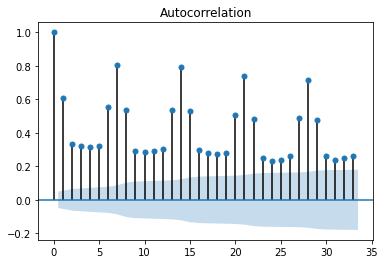

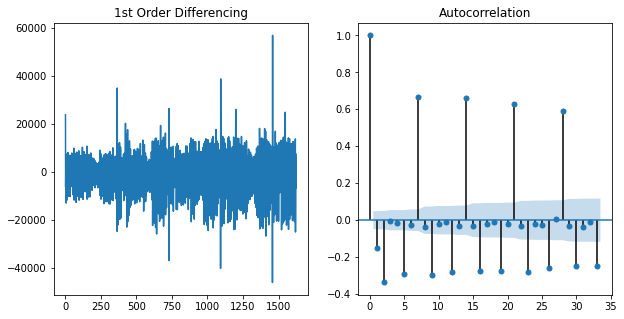

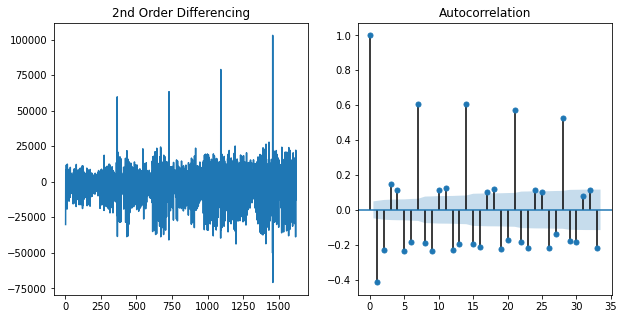

p-value without differencing: 0.05271596120097195
p-value 1st order differencing: 5.4341328584164576e-17
p-value 2nd order differencing: 0.0


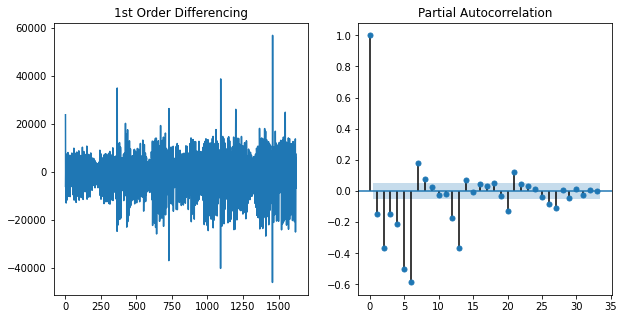

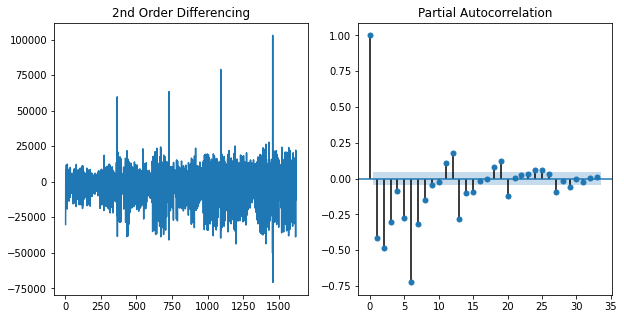

In [ ]:
# ARIMA model

# first plotting the differencing in order to determine the difference metric for the ARIMA model. Based on the visualization of the plots, we
# can determine the differencing metric. We want to difference the data until it becomes stationary, which will tell us the desired outcome
plot_acf(df_train_xy.y)

# Note that for determining q, we look at the ACF plots in order to determine the number of lagged forecast errors. We need to determine the amount
# of lags crossing the threshold to map out the value of q.
fig = plt.figure(figsize=(10,5))
axis_1 = fig.add_subplot(121)
axis_1.plot(df_train_xy.y.diff())
axis_1.set_title('1st Order Differencing')

axis_2 = fig.add_subplot(122)
plot_acf(df_train_xy.y.diff().dropna(), ax=axis_2)
plt.show()

fig = plt.figure(figsize=(10,5))
axis_1 = fig.add_subplot(121)
axis_1.plot(df_train_xy.y.diff().diff())
axis_1.set_title('2nd Order Differencing')

axis_2 = fig.add_subplot(122)
plot_acf(df_train_xy.y.diff().diff().dropna(), ax=axis_2)
plt.show()

# ADF test - this can be used as well in order to determine the difference metric for the ARIMA model.
# based on the first differencing p-value that is below 0.05 will tell us if it is stationary. Based on my tests,
# the data becomes stationary at the first order of differencing.
print('p-value without differencing: ' + str(adfuller(df_train_xy.y.dropna())[1]))
print('p-value 1st order differencing: ' + str(adfuller(df_train_xy.y.diff().dropna())[1]))
print('p-value 2nd order differencing: ' + str(adfuller(df_train_xy.y.diff().diff().dropna())[1]))

# Next to determine the p value of the model. To do so, we must make the data stationary in order to determine the number of lags of Y for prediction.
# By plotting the partial auto correlation of the data, we determine whether the lag order is needed for the model
fig = plt.figure(figsize=(10,5))
axis_1 = fig.add_subplot(121)
axis_1.plot(df_train_xy.y.diff())
axis_1.set_title('1st Order Differencing')

axis_2 = fig.add_subplot(122)
plot_pacf(df_train_xy.y.diff().dropna(), ax=axis_2)
plt.show()

fig = plt.figure(figsize=(10,5))
axis_1 = fig.add_subplot(121)
axis_1.plot(df_train_xy.y.diff().diff())
axis_1.set_title('2nd Order Differencing')

axis_2 = fig.add_subplot(122)
plot_pacf(df_train_xy.y.diff().diff().dropna(), ax=axis_2)
plt.show()


arima = ARIMA(df_train_xy.y, order=(1,1,2))
arima_predict = arima.fit()
prediction = arima_predict.forecast(60)[0]

In [ ]:
arima_predictions = pd.DataFrame({'ds': prophet_forecast.ds.tail(60), 'y': prediction})
arima_predictions.to_csv('arima_predictions.csv', index=False)

In [ ]:
prophet_predictions = prophet_forecast[['ds', 'yhat']].copy().tail(60)
prophet_predictions.rename(columns = {'yhat':'y'}, inplace = True)

prophet_predictions.to_csv('prophet_predictions.csv', index=False)